# Поиск оптимальной стратегии методом Q-learning

Реализуем поиск оптимальной стратегии по TD методу Q-learning. Код для "табличного" агента у нас уже написан. Его можно использовать без изменений.

In [5]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = 0.1):
        self.nA = env.action_space.n # число действий
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)
    
    # выбор жадного действия        
    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки с постоянным шагом обновления
        self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
        
    def get_Q(self, state, act):
        return self.Q[state][act]
  
    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

Далее, напишем управляющую функцию `QLearning_control()` для обучения агента по методу Q-learning. Код аналогичен методу `SARSA_control()`, кроме способа формирования цели обновления. 

In [7]:
from tqdm import tqdm
    
# алгоритм обучения
def QLearning_control(env, agent, n_episodes=10000, gamma = 1.0, 
                      eps_start=0.5, eps_decay = 1.0, eps_min = 0.01):
    agent.eps = eps_start
    
    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()
        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            best_action = agent.best_action(next_state)           
            upd_goal = reward + gamma * agent.get_Q(next_state, best_action)
            agent.update(state, action, upd_goal)
            
            state = next_state
            if terminated or truncated:
                break
        # уменьшение доли шагов исследования
        agent.eps = max(agent.eps * eps_decay, eps_min)     

### Пример 1

Рассмотрим снова задачу о клеточном мире с утёсом `CliffWalking-v0` и найдём оптимальную стратегию методом Q-learning.

In [9]:
import gymnasium as gym
# Создание среды
env = gym.make('CliffWalking-v0')
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env, alpha = 0.25, eps=0.01)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, eps_decay = 0.95, eps_min = 0.001)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2931.80it/s]


Выведем график доходов за эпизоды, полученных в взаимодействия агента со средой.

In [11]:
import matplotlib.pyplot as plt
# для того, чтобы избежать ошибок при построении графиков
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 0)
    plt.show()

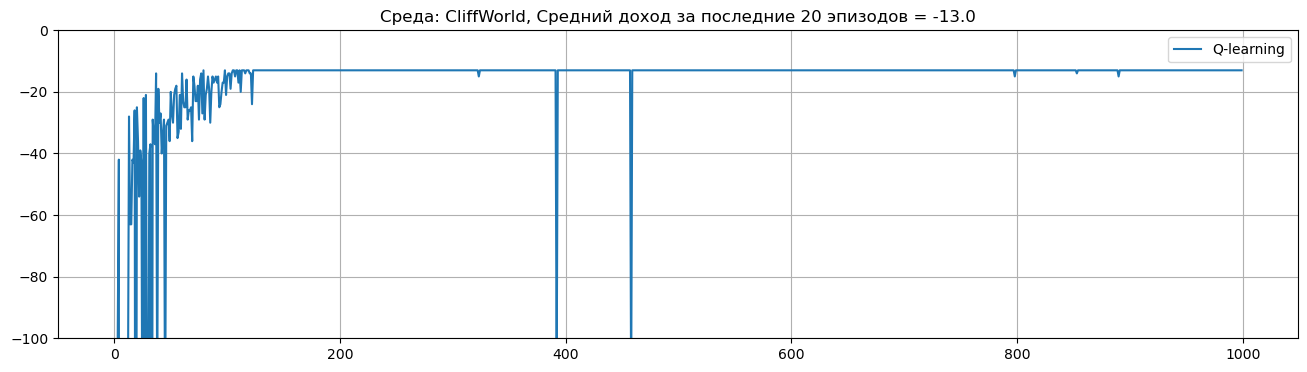

In [13]:
# график доходов
returns = np.array(env.return_queue)
plot_rewards("CliffWorld", returns, 'Q-learning')

График доходов по эпизодам показывает, что уже к 200 эпизоду агент достиг фиксированной стратегии. Общий доход оптимален. Рассмотрим стратегию, которой обучился агент.

In [15]:
import time
from IPython.display import clear_output

env = gym.make("CliffWalking-v0", render_mode='ansi')

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    
    time.sleep(.4)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x




В отличие от SARSA, целевая стратегия детерминированная, в ней нет исследования и нет шанса свалиться с утёса. Агент действительно научился кратчайшему пути вдоль утёса.

Продемострируем также тот эффект, что агент обучается даже, когда взаимодействие идёт по исследовательской стратегии.

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 674.64it/s]


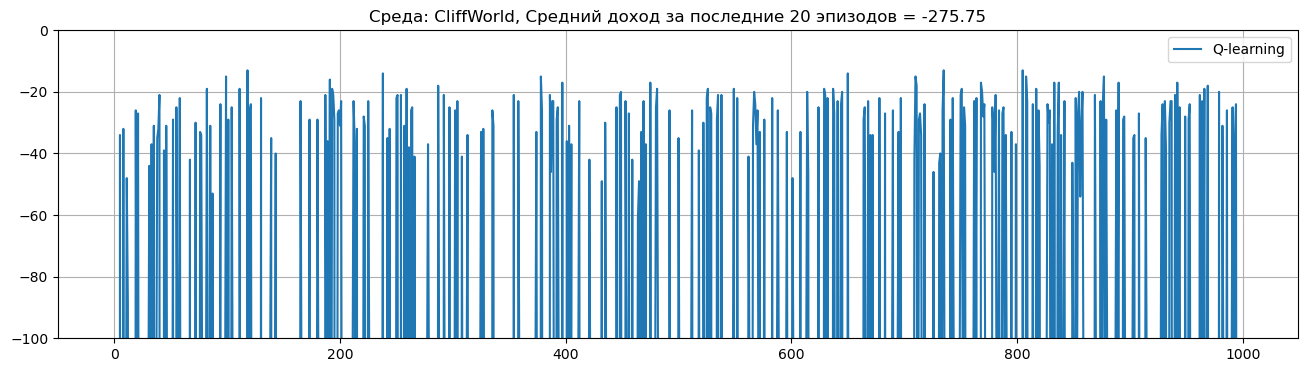

In [17]:
import gymnasium as gym
# Создание среды
env = gym.make('CliffWalking-v0')
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env, alpha = 0.25)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, eps_decay = 1.0)

# график доходов
returns = np.array(env.return_queue)
plot_rewards("CliffWorld", returns, 'Q-learning')

В ходе взаимодействия агент показывает не слишком хороший результат. Но тем не менее он уже обучился оптимальной стратегии.

In [19]:
import time
from IPython.display import clear_output

env = gym.make("CliffWalking-v0", render_mode = 'ansi')
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
env.close()
print("Доход равен ", env.return_queue[-1])

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x


Доход равен  -13.0


Итоговый доход действительно оптимален.

### Пример 2

Применим метод Q-learning для решения задачи о такси `Taxi-v3`.

In [21]:
import gymnasium as gym
# Создание среды
env = gym.make('Taxi-v3')
n_episodes = 5000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агнета
agent = TableAgent(env, alpha = 0.25)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 857.22it/s]


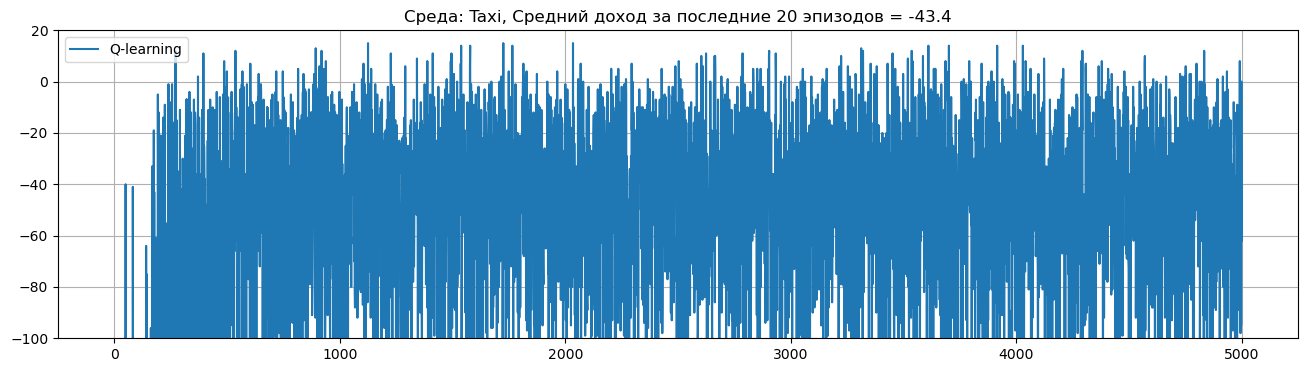

In [23]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 20)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("Taxi", returns, 'Q-learning')

График вознаграждений выводится для фактически полученных вознаграждений из траекторий, генерируемых по eps-жадной стратегии. Сам агент уже обучился оптимальной стратегии действий. В этом можно убедиться в симуляции.

In [25]:
n_episodes = 10000
env = gym.make("Taxi-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent.play(env, n_episodes)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4170.65it/s]


Средний доход за эпизод равен: 7.9592
Минимальный доход за эпизод равен: 3.0
Максимальный доход за эпизод равен: 15.0


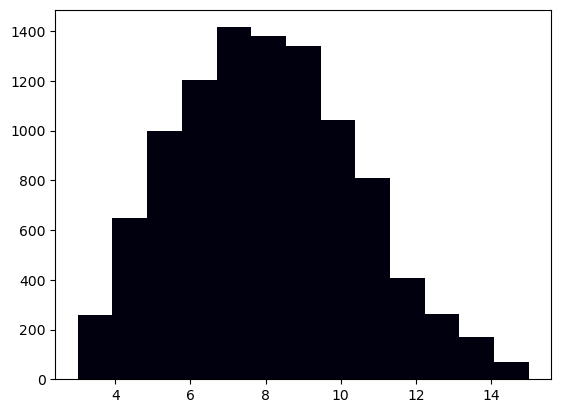

In [29]:
print('Средний доход за эпизод равен:', np.mean(env.return_queue))
print('Минимальный доход за эпизод равен:', np.min(env.return_queue))
print('Максимальный доход за эпизод равен:', np.max(env.return_queue))

import matplotlib.pyplot as plt
plt.hist(env.return_queue, bins=13, color='#00000f')
plt.show()

### Пример 3

Применим метод Q-learning для задачи `FrozenLake`.

In [33]:
import gymnasium as gym
# Создание среды
env = gym.make("FrozenLake-v1")
n_episodes = 10000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агнета
agent = TableAgent(env, alpha = 0.1)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, gamma=0.99)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2784.59it/s]


Отметим, что при `gamma=1` агент не будет стремиться быстрее завершить эпизод, в итоге полученная стратегия будет просто избегать попадания в ямы.

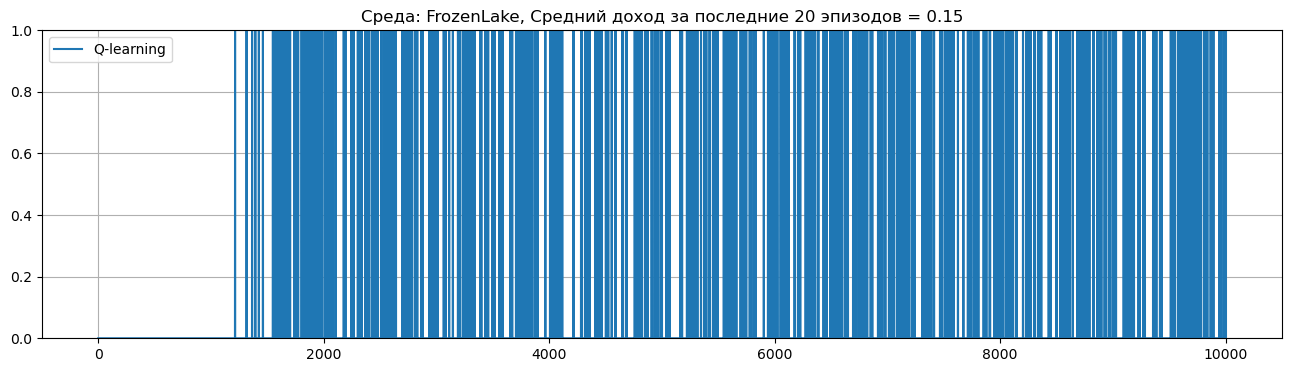

In [35]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("FrozenLake", returns, 'Q-learning')

График вознаграждений выводится для фактически полученных вознаграждений из траекторий, генерируемых по eps-жадной стратегии. Сам агент уже обучился оптимальной стратегии действий. В этом можно убедиться в симуляции.

In [36]:
n_episodes = 10000
env = gym.make("FrozenLake-v1", max_episode_steps = 1000)
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent.play(env, n_episodes)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1585.27it/s]


In [38]:
print('Средний доход за эпизод равен:', np.mean(env.return_queue))

Средний доход за эпизод равен: 0.825


Действительно, среднее вознаграждение показывает среднее число успешно завершённых эпизодов, почти 83%. 

Ниже можно запустить визулизацию действий агента.

In [42]:
from time import sleep
from IPython.display import clear_output

env = gym.make("FrozenLake-v1", render_mode = 'ansi', max_episode_steps = 1000)
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) # выбрать действие случайно
    
    time.sleep(.1)
    clear_output(wait=True)      
    print(env.render())
    if terminated or truncated:
        break
    
env.close()
print("Доход равен ", env.return_queue[-1])

  (Down)
SFFF
FHFH
FFFH
HFFG

Доход равен  1.0


Можно также вытащить обученную стратегию более наглдяно с помощью кода ниже.

In [33]:
optPolicy = dict((k,agent.best_action(k)) for k, v in list(agent.Q.items()))

action_labels = {0:"LEFT", 1:"DOWN", 2: "RIGHT", 3:"UP"}
optimal_actions=[0]*16
for i in range(4):
    for j in range(4):
        if 4*i+j in optPolicy:
            optimal_actions[4*i+j] = action_labels[optPolicy[4*i+j]]
        else:
            optimal_actions[4*i+j] = "ANY"


print("Стратегия:\n",np.array(optimal_actions).reshape((4,4)))

Стратегия:
 [['LEFT' 'UP' 'UP' 'UP']
 ['LEFT' 'LEFT' 'RIGHT' 'LEFT']
 ['UP' 'DOWN' 'LEFT' 'LEFT']
 ['LEFT' 'RIGHT' 'DOWN' 'LEFT']]


Полученная стратегия соответствует оптимальной стратегии, найденной в методами ДП.

Ниже можно посмотреть на значения обученной Q-функции.

In [35]:
agent.Q

defaultdict(<function __main__.TableAgent.__init__.<locals>.<lambda>()>,
            {0: array([0.58038594, 0.55509532, 0.55873155, 0.55999827]),
             1: array([0.2918135 , 0.37160451, 0.32837484, 0.53989856]),
             5: array([0., 0., 0., 0.]),
             4: array([0.59408877, 0.42026947, 0.42847975, 0.35529302]),
             8: array([0.38191374, 0.53251027, 0.41228942, 0.63223633]),
             9: array([0.43637537, 0.70530092, 0.46531583, 0.38467758]),
             12: array([0., 0., 0., 0.]),
             13: array([0.4343197 , 0.48150313, 0.79413696, 0.43804438]),
             2: array([0.42741896, 0.40587163, 0.37683137, 0.4703643 ]),
             6: array([0.31934348, 0.24324792, 0.43732478, 0.14350619]),
             10: array([0.72869627, 0.5333162 , 0.40755173, 0.29883273]),
             7: array([0., 0., 0., 0.]),
             3: array([0.24968146, 0.29518447, 0.26047604, 0.41843571]),
             14: array([0.75186399, 0.85153678, 0.84134522, 0.81221245]